## Problem Set 2: Merging and regular expressions

### Authors: Mike DeMayo, Jed Seiner, Bill Zheng

**Total points (without extra credit)**: 30

**Background on the policy context**: here, we're going to use two datasets to practice reshaping, merging, and regular expression patterns. Both datasets relate to the broader issue of which employers might be violating the rights of temporary guestworkers granted visas under the H-2A program. Here are some articles about potential exploitation of guestworkers by firms and inequality caused by minimal oversight:

- News media coverage of labor abuses of temporary guestworkers: https://www.buzzfeednews.com/article/kenbensinger/the-pushovers
- GAO report on labor abuses of temporary guestworkers: https://www.gao.gov/products/gao-15-154

The following datasets are located in `pset2_inputdata` (need to unzip):

- `jobs_clean`: a dataset of guestworker jobs posted by many employers, some of whom have been debarred (banned) from the program for labor abuses; others not debarred
- `debar`: a dataset of employers who committed violations of labor regulations meant to protect temporary guestworkers


You can view a codebook here: https://docs.google.com/spreadsheets/d/1rF9GJEC8pPKxipD0TsoG9DVdqz3EJ-b-BHEtyioAX7I/edit?usp=sharing


In [31]:
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import os

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# for geocoding part, taken from websites
from geopy.geocoders import Nominatim
from time import sleep


# 1. Reshaping data (13 points total)

Load the following dataset stored in `pset2_inputdata`: `debar.csv`

This represents employers temporarily banned from hiring workers (debar.csv); call this `debar`


View the head()


In [32]:
debar = pd.read_csv("/content/debar.csv")
debar.head()


,Name,"City, State",Violation,Duration,Start date,End date
0,J&J Harvesting,"Leads, ND",Failure to respond to audit (partial response),2 years,1/19/2014,1/18/2016
1,"Stahlman Apiaries, Inc","Selby, SD",Failure to respond to audit (partial response),1 year,2/19/2015,2/14/2016
2,Trust Nursery,"Pulaski, NY",Failure to respond to audit (partial response),1 year,3/21/2014,3/20/2015
3,Anton Fertilizer Inc.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016
4,"Great Plains Fluid Service, Inc.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016


## 1.1 (1 point)

Print the number of rows in `debar` versus the number of unique employer names (`Name`). Is there one row per employer or multiple rows for some employers?

In [33]:
# Printing number of rows
print("Number of rows:", len(debar))

# Printing number of unique employer names
print("Number of unique employer names", debar["Name"].nunique())

Number of rows: 114
Number of unique employer names 98


- There are multiple rows for some employers leading for there to be more rows than unique employer names. Consider the following example where there are employers with more than one row in the dataset:

In [34]:
print(debar.Name.value_counts())

Name
Caddo Creek Ranch, dba Paradise Ranch                             2
Autumn Hill Orchard                                               2
Maple Ridge Custom Services, LLC                                  2
Old Tree Farms/Verpaalen Custom Service                           2
Annabella Land & Cattle                                           2
                                                                 ..
Walker Place                                                      1
County Fair Farm (company) and Andrew Williamson (individual)*    1
Jesus Ledesma                                                     1
B & R Harvesting and Paul Cruz (individual)                       1
Delia Rojas                                                       1
Name: count, Length: 98, dtype: int64


## 1.2 Investigating duplicated rows (2 points)

A. Create a new column in `debar`--`is_repeated`-- that tells us whether an employer (`Name`) is repeated > 1 times

*Hint*: there are multiple ways to solve this but some possibilities to get the list of names that are repeated are:
- Using value_counts() on the `Name` variable and extracting the index from that value counts
- Using groupby to count the rows attached to one name

B. Print the rows where `is_repeated == True` and interpret

C. Subset to the rows where `is_repeated == True` and save that data as `mult_debar`. Print the head() and shape

In [35]:
# Using value_counts() to figure out which names are repeated in the dataset
repeated_employers = debar.Name.value_counts()
repeated_employers = repeated_employers[repeated_employers > 1].index

# Creating repeated names col
debar["is_repeated"] = debar.Name.isin(repeated_employers)

# Printing rows where is_repeated == True
print("Repeated offenders: \n", debar[debar["is_repeated"] == True])

mult_debar = debar[debar["is_repeated"] == True]

# Head and shape:
mult_debar.head()
mult_debar.shape

mult_debar.Name.nunique()

mult_debar


Repeated offenders: 
                                         Name       City, State  \
6                    Annabella Land & Cattle     Annabella, UT   
7                        Autumn Hill Orchard        Groton, MA   
8      Caddo Creek Ranch, dba Paradise Ranch         Caddo, TX   
11                     Loewen Harvesting LLC   Brownsville, TX   
12               Rollo Farm Labor Contractor         Miami, FL   
14                             Sharon Mathis        Tifton, GA   
15                                 SRT Farms        Morton, TX   
16                               Mark Duncan     Roosevelt, UT   
17          Maple Ridge Custom Services, LLC     Altheimer, AK   
18                                 F&W Farms       Ingalls, KS   
19                        Cisco Produce Inc.         Cairo, GA   
21   Old Tree Farms/Verpaalen Custom Service         Volga, SD   
24               Rollo Farm Labor Contractor         Miami, FL   
25                     Loewen Harvesting LLC    Brownf

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True


(32, 7)

16

,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownsville, TX",Failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",Failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AK",Failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


- There are 32 rows within the mult_debar dataset, however, there are only 16 unique companies. That means these 16 companies have repeated violations, or there is a dataset error in which some of the violations are written down slightly differently but really refer to the same violation. For example: "Dove Creek Farms" has the same "Failure to respond to audit request" and the same dates, but the capitalization of the second "violation" is a bit different and therefore is filed twice in the data.

## 1.3 Reshape mult_debar to wide to begin filtering out duplicates (4 points)

You want to separate out two cases:

- Cases where the repeat rows for one employer are due to duplicated data
- Cases where the repeat rows for one employer represent repeated violations for different issues

There are various ways to check duplicates in this data (eg converting `Violation` to lowercase; replacing spelled-out states with two-dig state codes)

We're going to use the simple rule of:

- A row is a duplicate if, within an employer (defined by Name + City, State), the Start date for each row's violation is the same

To begin to check this, reshape `mult_debar` to a wide dataframe (`mult_debar_wide`) with the following columns, treating the `Name` and `City, State` as the index for the pivot:

- Name
- City, State
- start_date_viol1
- start_date_viol2

Print the head and shape

In [36]:
# Cleaning the data for state abbreviations and lower-case violations (lower-case technically not necessary)
state_abbrev = {
    'Texas': 'TX',
    'Utah': 'UT',
    'Georgia': 'GA',
    'Brownsville, TX': 'Brownfield, TX',
    'Altheimer, AK': 'Altheimer, AR'
}

# NEED TO CHANGE brownsville TO brownsfield. AK to AR

mult_debar['City, State'] = mult_debar['City, State'].replace(state_abbrev, regex = True)
clean_mult_debar = mult_debar
clean_mult_debar['Violation'] = clean_mult_debar['Violation'].apply(lambda x: x.lower() if isinstance(x, str) else x)
clean_mult_debar

<ipython-input-36-e48bbaef2323>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_debar['City, State'] = mult_debar['City, State'].replace(state_abbrev, regex = True)
<ipython-input-36-e48bbaef2323>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_mult_debar['Violation'] = clean_mult_debar['Violation'].apply(lambda x: x.lower() if isinstance(x, str) else x)


,Name,"City, State",Violation,Duration,Start date,End date,is_repeated
6,Annabella Land & Cattle,"Annabella, UT",non payment,1 year,5/9/2014,5/9/2015,True
7,Autumn Hill Orchard,"Groton, MA",failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,True
8,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,True
11,Loewen Harvesting LLC,"Brownfield, TX",failure to respond to audit (partial response),1 year,8/20/2014,8/19/2015,True
12,Rollo Farm Labor Contractor,"Miami, FL",failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,True
14,Sharon Mathis,"Tifton, GA",failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
15,SRT Farms,"Morton, TX",failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
16,Mark Duncan,"Roosevelt, UT",failure to respond to audit (no response),2 years,11/16/2014,11/15/2016,True
17,"Maple Ridge Custom Services, LLC","Altheimer, AR",failure to respond to audit (partial response),2 years,11/16/2014,11/15/2016,True
18,F&W Farms,"Ingalls, KS",failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,True


In [37]:
# Sorting to ensure consistent ordering
mult_debar_sorted = clean_mult_debar.sort_values(['Name', 'City, State', 'Start date'])

# Create a unique violation identifier to help with wide
mult_debar_sorted['violation_number'] = mult_debar_sorted.groupby(['Name', 'City, State']).cumcount() + 1
#mult_debar_sorted

# Pivoting to wide
mult_debar_wide = mult_debar_sorted.pivot_table(
    index=['Name', 'City, State'],
    columns='violation_number',
    values='Start date',
    aggfunc='first'
)

# Renaming columns
mult_debar_wide.columns = [f'start_date_viol{col}' for col in mult_debar_wide.columns]

mult_debar_wide = mult_debar_wide.reset_index()

mult_debar_wide
mult_debar_wide.head()
mult_debar_wide.shape

,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018
5,F&W Farms,"Ingalls, KS",12/10/2014,12/10/2014
6,Loewen Harvesting LLC,"Brownfield, TX",8/20/2014,8/20/2014
7,Macky and Brad Farms,"Plains, TX",2/13/2015,2/13/2015
8,"Maple Ridge Custom Services, LLC","Altheimer, AR",11/16/2014,11/16/2014
9,Mark Duncan,"Roosevelt, UT",11/16/2014,11/16/2014


,Name,"City, State",start_date_viol1,start_date_viol2
0,Annabella Land & Cattle,"Annabella, UT",5/9/2014,5/9/2014
1,Autumn Hill Orchard,"Groton, MA",7/6/2014,7/6/2014
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",7/20/2014,7/20/2014
3,Cisco Produce Inc.,"Cairo, GA",12/10/2014,12/10/2015
4,Dove Creek Farms,"Mount Vernon, TX",2/9/2018,2/9/2018


(16, 4)

## 1.4 Filter out duplicates from original debar data (6 points)

A. Using `mult_debar_wide`, add a column `is_dup` that takes value of True for cases where start_date_viol1 == start_date_viol2 marking the row as a duplicate

B. Going back to the original long-format data you loaded at the beginning- `debar`
    - For employers where `is_dup == True` as indicated by your wide-format dataframe, only keep `violnum == viol1`
    - For all other employers (so is_dup == False and ones we didnt need to check duplicates for), keep all violnum
    - Remove the `is_repeated` column from the `debar` data

**Hint**: you can complete part B without a for loop; `pd.concat` with axis = 0 (row binding) is one way

Call the resulting dataframe `debar_clean` and print the shape and # of unique employer names

In [55]:
# New 'is_dup' label
mult_debar_wide['is_dup'] = (mult_debar_wide['start_date_viol1'] == mult_debar_wide['start_date_viol2'])
#mult_debar_wide

# Duplicate employers
dup = mult_debar_wide[mult_debar_wide['is_dup'] == True][['Name','City, State']]
dup

# Sorting so we can take the first violation
debar_sorted = debar.sort_values(['Name', 'City, State', 'Start date'])

# Taking the first violation from the duplicate employers
dup_cleaned = debar_sorted[
    (debar_sorted['Name'].isin(dup['Name'])) &
    (debar_sorted['City, State'].isin(dup['City, State']))
].groupby(['Name', 'City, State']).first().reset_index()
#dup_cleaned

# Taking all non-duplicate instances
non_dup = debar[
    (~ (debar_sorted['Name'].isin(dup['Name'])) |
    ~ (debar_sorted['City, State'].isin(dup['City, State'])))
]
#non_dup

# Combining duplicate and non-duplicate using pd.concat
debar_clean = pd.concat([dup_cleaned, non_dup], axis=0)

debar_clean = debar_clean.drop(columns=['is_repeated'])
debar_clean

print("Shape of debar_clean:", debar_clean.shape)

# 101, 6

print("Number of unique employer names:", debar_clean['Name'].nunique())

,Name,"City, State"
0,Annabella Land & Cattle,"Annabella, UT"
1,Autumn Hill Orchard,"Groton, MA"
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX"
4,Dove Creek Farms,"Mount Vernon, TX"
5,F&W Farms,"Ingalls, KS"
6,Loewen Harvesting LLC,"Brownfield, TX"
7,Macky and Brad Farms,"Plains, TX"
8,"Maple Ridge Custom Services, LLC","Altheimer, AR"
9,Mark Duncan,"Roosevelt, UT"
11,Rollo Farm Labor Contractor,"Miami, FL"


<ipython-input-55-6e8c50716ed8>:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_dup = debar[


,Name,"City, State",Violation,Duration,Start date,End date
0,Annabella Land & Cattle,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015
1,Autumn Hill Orchard,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016
2,"Caddo Creek Ranch, dba Paradise Ranch","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016
3,Dove Creek Farms,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018
4,F&W Farms,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016
...,...,...,...,...,...,...
107,Walker Place,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020
108,County Fair Farm (company) and Andrew Williams...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020
110,Jesus Ledesma,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
112,B & R Harvesting and Paul Cruz (individual),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20


Shape of debar_clean: (105, 6)
Number of unique employer names: 98


# 2. Merging and regex (17 points total)



## 2.1 Load data on job postings

The previous dataset contains a small subset of employers who faced temporary bans due to violations of H-2A program regulations

Since most of the bans have expired, we're going to see which of those employers posted new H-2A jobs in the first quarter of 2021

Loading the `jobs_clean.csv` data stored in `pset2_inputdata`

In [39]:
# your code here to load the data
jobs = pd.read_csv("/content/jobs.csv")
jobs
#jobs.head()
#jobs.shape

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"Fazio Farms Operating Company, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,Charlie Sunderland,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Michael Rudebusch,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,Lodahl Farms,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"Dunson Harvesting, Inc.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,James L Schneller,NaN,...,N,1,N,NaN,12.68,55.0,12709914373,jims4463@aol.com,NaN,0
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Stephen G Myers,NaN,...,N,1,N,NaN,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,Andy Povey,Andy Povey Farms,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"Silver Creek Seed, LLC",NaN,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0


##  2.2 Try inner join on employer name  (2 points)

- Use the `EMPLOYER_NAME` field of the `jobs` dataset
- Use the `Name` field of the `debar_clean` dataset

A. Use pd.merge with an inner join on those fields to see whether there are any exact matches.

B. If there are exact matches, print the row(s) with exact matches



In [40]:
# Merged
merged = jobs.merge(debar_clean, left_on='EMPLOYER_NAME', right_on='Name', how = 'inner')
merged

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,Name,"City, State",Violation,Duration,Start date,End date
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,Rafael Barajas,NaN,...,18632732686,NaN,https://seasonaljobs.dol.gov/,7,Rafael Barajas,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017


- Only 1 exact match with Employer Name and Name from jobs and debar_clean respectively.

## 2.3 Targeted regex (10 points total)

You want to see if you can increase the exact match rate with some basic cleaning of each
of the employer name fields in each dataset

### 2.3.1 Converting to upper (2 points)

A. Convert the `EMPLOYER_NAME` and `Name` fields to uppercase using list comprehension rather than df.varname.str.upper() (it's fine to do a separate list comprehension line for each of the two columns)

B. Print a random sample of 15 values of each result

C. Assign the full vector of uppercase names back to the original data, writing over the original `EMPLOYER_NAME` and `Name` columns


In [41]:
## insert your code to turn into uppercase here
jobs_upper = [name.upper() for name in jobs['EMPLOYER_NAME']]
debar_upper = [name.upper() for name in debar_clean['Name']]

In [42]:
## insert your code for the random sample

#np.randomchoice(15)

random.sample(jobs_upper, 15)
random.sample(debar_upper, 15)

['FAIRVIEW FARMS INC',
 'TIM GANN',
 'WONDERFUL BEES',
 "BEGGER'S DIAMOND V RANCH, INC.",
 'FAIRCHILD SHEARING LLC',
 'LANCE & LISA FUNK PARTNERSHIP',
 'PETE AND RAMA PARIS FAMILY TRUST',
 'RAASCH BROTHERS, LLC',
 'AO HARVESTING, LLC.',
 'SHARIDEN FARMS PARTNERSHIP',
 'ERIC P LINK',
 'VALERA BROTHERS CUSTOM HARVESTING',
 'WESTERN RANGE ASSOCIATION',
 'INTERGROW GREENHOUSES INC',
 'S. DAVID EARL']

['J & L FARMS',
 'XAVIER HORNE',
 'TRIANGLE J FARMS',
 'TRINITY LIVESTOCK PARTNERSHIP',
 'ROBERT D. TOWLES',
 'AVOYELLES HONEY CO., LLC',
 'JIM AND ANN SHIPLEY WILLIAM SHIPLEY*',
 'SLASH E.V. RANCH LLP',
 'LOEWEN HARVESTING LLC',
 'LABATTE FARMS',
 'MYRKA MIREYA CARDENAS',
 'AGECY I LLC',
 'LOV RANCH CO, LLLP DBA LOV RANCH',
 'FIRST AMERICAN HOLDING',
 'YESENIA PEREZ']

In [43]:
## insert your code for assigning the uppercase names back to the data
jobs['EMPLOYER_NAME'] = jobs_upper
debar_clean['Name'] = debar_upper

jobs
debar_clean

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,ADDENDUM_B_HOUSING_ATTACHED,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS
0,H-300-20199-721302,Determination Issued - Withdrawn,2020-07-17 14:50:40.840,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,Y,"FAZIO FARMS OPERATING COMPANY, LLC",NaN,...,N,1,Y,12.68,12.68,55.0,13607017661,faziofarms@gmail.com,NaN,0
1,H-300-20231-773906,Determination Issued - Certification,2020-08-20 10:38:15.620,2020-10-01 00:00:00.000,Association - Agent,N,Seasonal,N,CHARLIE SUNDERLAND,Panter & Sunderland Nursery,...,N,1,N,NaN,12.68,55.0,19318083783,NaN,https://www.jobs4tn.gov/vosnet/Default.aspx,0
2,H-300-20231-774123,Determination Issued - Certification,2020-08-24 15:33:14.340,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,MICHAEL RUDEBUSCH,NaN,...,N,1,N,NaN,12.68,55.0,19369333827,fayethlynpitre@rocketmail.com,NaN,0
3,H-300-20231-774151,Determination Issued - Certification,2020-08-21 12:08:09.760,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,LODAHL FARMS,NaN,...,Y,2,N,NaN,12.68,55.0,14069637560,lodahl_kelsey@yahoo.com,NaN,0
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,Y,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,H-300-20351-963307,Determination Issued - Certification,2020-12-17 10:34:09.530,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,JAMES L SCHNELLER,NaN,...,N,1,N,NaN,12.68,55.0,12709914373,jims4463@aol.com,NaN,0
2716,H-300-20351-963399,Determination Issued - Certification,2020-12-17 14:37:57.920,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,STEPHEN G MYERS,NaN,...,N,1,N,NaN,12.68,55.0,12708780028,vjpm76@gmail.com,https://kentucky.gov/employment/Pages/default....,1
2717,H-300-20351-964097,Determination Issued - Certification,2020-12-22 12:21:32.370,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,ANDY POVEY,Andy Povey Farms,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0
2718,H-300-20351-965435,Determination Issued - Certification,2020-12-22 12:18:43.280,2020-12-31 00:00:00.000,Individual Employer,N,Seasonal,N,"SILVER CREEK SEED, LLC",NaN,...,Y,2,Y,12.68,12.68,55.0,NaN,H-2AJobs@snakeriverfarmers.org,https://idahoworks.gov/ada/r/job_seeker,0


,Name,"City, State",Violation,Duration,Start date,End date
0,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015
1,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016
2,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016
3,DOVE CREEK FARMS,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018
4,F&W FARMS,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016
...,...,...,...,...,...,...
107,WALKER PLACE,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020
110,JESUS LEDESMA,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20
112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20


### 2.3.2 Cleaning up punctuation (4 points)

You notice that INC, CO, and LLC are sometimes followed by a period (.) but sometimes not

A. For each dataset, write a regex pattern using `re.sub` to remove the . but only if it's preceded by INC, LLC, or CO

Make sure LLC, INC, CO remain part of the string but just without the dot

B. Test the pattern on the positive and negative example we provide below and print the result. See the Github issue for examples of what to return


**Hint**: https://stackoverflow.com/questions/7191209/python-re-sub-replace-with-matched-content



In [44]:
pos_example_1 = "CISCO PRODUCE INC."
pos_example_2 = "AVOYELLES HONEY CO., LLC"
neg_example = "E.V. RANCH LLP"

In [45]:
## insert your code here with the regex pattern for part A
def clean_suffix(name):
    return re.sub(r'(INC|LLC|CO)\.', r'\1', name)

#jobs['EMPLOYER_NAME'] = jobs['EMPLOYER_NAME'].apply(clean_suffix)
#debar_clean['Name'] = debar_clean['Name'].apply(clean_suffix)

## insert your code to use re.sub to apply the pattern to the test cases for part B
clean_suffix(pos_example_1)
clean_suffix(pos_example_2)
clean_suffix(neg_example)

'CISCO PRODUCE INC'

'AVOYELLES HONEY CO, LLC'

'E.V. RANCH LLP'

### 2.3.3 (4 points)

Use that pattern in conjunction with `re.sub` and list comprehension to clean the employer name columns in each dataset. Save the new columns as `name_clean` in each. Then, use row subsetting to (1) subset to rows that changed names and (2) for:

- `debar_clean` print the `Name` and `name_clean` columns
- `jobs` print the `EMPLOYER_NAME` and `name_clean` columns

Make sure to use the uppercase versions of the variables


In [46]:
## your code here to clean the columns
jobs['name_clean'] = [re.sub(r'(INC|LLC|CO)\.', r'\1', name) for name in jobs['EMPLOYER_NAME']]
debar_clean['name_clean'] = [re.sub(r'(INC|LLC|CO)\.', r'\1', name) for name in debar_clean['Name']]

jobs_changed = jobs[jobs['EMPLOYER_NAME'] != jobs['name_clean']]
debar_changed = debar_clean[debar_clean['Name'] != debar_clean['name_clean']]

jobs_changed[['EMPLOYER_NAME', 'name_clean']]
debar_changed[['Name', 'name_clean']]

,EMPLOYER_NAME,name_clean
4,"DUNSON HARVESTING, INC.","DUNSON HARVESTING, INC"
7,"FARM LABOR ASSOCIATION FOR GROWERS, INC.","FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,"MCLAIN FARMS, INC.","MCLAIN FARMS, INC"
17,"BONNIE PLANTS, INC.","BONNIE PLANTS, INC"
18,"B & W QUALITY GROWERS, INC.","B & W QUALITY GROWERS, INC"
...,...,...
2700,HARRAL LIVESTOCK CO. LLC,HARRAL LIVESTOCK CO LLC
2701,ECOSYSTEM CONCEPTS INC.,ECOSYSTEM CONCEPTS INC
2702,SIDDOWAY SHEEP CO.,SIDDOWAY SHEEP CO
2705,SATHER MANAGEMENT INC.,SATHER MANAGEMENT INC


,Name,name_clean
3,ANTON FERTILIZER INC.,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","GREAT PLAINS FLUID SERVICE, INC"
5,PROMAX INC.,PROMAX INC
13,REIMER'S INC.,REIMER'S INC
19,CISCO PRODUCE INC.,CISCO PRODUCE INC
23,REIMER’S INC.,REIMER’S INC
33,GERONIMO SHEEP CO.,GERONIMO SHEEP CO
46,ALTENDORF TRANSPORT INC.,ALTENDORF TRANSPORT INC
56,CISCO PRODUCE INC.,CISCO PRODUCE INC
72,"SAXTONS RIVER ORCHARDS, INC.","SAXTONS RIVER ORCHARDS, INC"


In [47]:
## your code here to print the head
jobs_changed.head()
debar_changed.head()

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_HOUSING_RECORDS,MEALS_PROVIDED,MEALS_CHARGED,MEAL_REIMBURSEMENT_MINIMUM,MEAL_REIMBURSEMENT_MAXIMUM,PHONE_TO_APPLY,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,name_clean
4,H-300-20231-774508,Determination Issued - Certification,2020-08-20 10:17:34.530,2020-10-01 00:00:00.000,Individual Employer,Y,Seasonal,N,"DUNSON HARVESTING, INC.","Dunson Harvesting, Inc.",...,8,N,NaN,12.68,55.0,18632939888,NaN,www.employflorida.com,4,"DUNSON HARVESTING, INC"
7,H-300-20233-780540,Determination Issued - Certification (Expired),2020-09-04 14:26:00.270,2020-10-01 00:00:00.000,Association - Joint Employer,N,Seasonal,N,"FARM LABOR ASSOCIATION FOR GROWERS, INC.",NaN,...,1,Y,13.5,13.50,55.0,17605922256,flag@sfcos.com,NaN,9,"FARM LABOR ASSOCIATION FOR GROWERS, INC"
14,H-300-20240-791807,Determination Issued - Certification (Expired),2020-09-17 18:57:56.030,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,"MCLAIN FARMS, INC.",NaN,...,1,N,NaN,12.68,55.0,19125268436,kim@mclainfarms.com,NaN,1,"MCLAIN FARMS, INC"
17,H-300-20244-795767,Determination Issued - Certification,2020-09-16 12:58:58.600,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,"BONNIE PLANTS, INC.",NaN,...,1,N,NaN,12.68,55.0,13343911328,dennis.ucles@bonnieplants.com,NaN,0,"BONNIE PLANTS, INC"
18,H-300-20245-799651,Determination Issued - Certification,2020-09-02 11:17:48.730,2020-10-01 00:00:00.000,Individual Employer,N,Seasonal,N,"B & W QUALITY GROWERS, INC.",NaN,...,33,N,NaN,12.68,55.0,17725711135,NaN,www.employflorida.com,7,"B & W QUALITY GROWERS, INC"


,Name,"City, State",Violation,Duration,Start date,End date,name_clean
3,ANTON FERTILIZER INC.,"Dighton, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,ANTON FERTILIZER INC
4,"GREAT PLAINS FLUID SERVICE, INC.","Greensburg, KS",Failure to respond to audit (no response),2 years,3/30/2014,3/29/2016,"GREAT PLAINS FLUID SERVICE, INC"
5,PROMAX INC.,"Whitewater, KS",Failure to Hire U.S. workers,2 years,5/15/2014,5/14/2016,PROMAX INC
13,REIMER'S INC.,"Lakin, KS",Failure to respond to audit (no response),2 years,8/23/2014,8/22/2016,REIMER'S INC
19,CISCO PRODUCE INC.,"Cairo, GA",Failure to respond to audit (no response),2 years,12/10/2014,12/9/2016,CISCO PRODUCE INC


## 2.4 More joins and more cleaning (5 points)

A. Conduct another inner join between `jobs` and `debar_clean` now using the `name_clean` column; print the result. Did the cleaning result in any more employers matched between the two datasets?

B. Create a new column in `debar_clean` called `name_clean_2` that uses regex to take the following name in that dataset:

- `SLASH E.V. RANCH LLP` in the `debar_clean` dataset

And cleans it up so that it matches with this employer in `jobs`

- `SLASH EV RANCH` in the `jobs` dataset

Eg a pattern to remove the dots in the EV and the space+LLP-- you can apply the pattern to all employer names in debar_clean (so don't need to worry about only applying it to that one employer)


C. Conduct a left join using `name_clean_2` as the join column where the left hand dataframe is `jobs`; right hand dataframe is `debar_clean`, store the result as a dataframe, and print the rows where the merge indicator indicates the row was found in both dataframe

**Note**: this manual cleaning process is inefficient and helps motivate why talked about fuzzy matching. Fuzzy matching could recognize that Slash EV ranch is a highly similar string to slash ev ranch llp and match them without us needing to use regex to make the strings identical.

In [48]:
## your code here
merged_cleaned = jobs.merge(debar_clean, left_on='name_clean', right_on='name_clean', how = 'inner')
merged_cleaned

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,EMAIL_TO_APPLY,WEBSITE_TO_APPLY,TOTAL_ADDENDUM_A_RECORDS,name_clean,Name,"City, State",Violation,Duration,Start date,End date
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,NaN,https://seasonaljobs.dol.gov/,7,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017


- Even after cleaning, the results of the join did not change. There is still only 1 employer that matched between the two datasets.

In [49]:
def clean_EV(name):
    # Remove dots
    name = re.sub(r'(\w)\.(\w)\.', r'\1\2', name)

    # Remove LLP
    name = re.sub(r'\s+LLP','',name)

    return name

clean_EV("SLASH E.V. RANCH LLP")

debar_clean['name_clean_2'] = debar_clean['name_clean'].apply(clean_EV)


merged_final_cleaned = jobs.merge(debar_clean, left_on='name_clean', right_on='name_clean_2')
merged_final_cleaned

'SLASH EV RANCH'

,CASE_NUMBER,CASE_STATUS,RECEIVED_DATE,DECISION_DATE,TYPE_OF_EMPLOYER_APPLICATION,H2A_LABOR_CONTRACTOR,NATURE_OF_TEMPORARY_NEED,EMERGENCY_FILING,EMPLOYER_NAME,TRADE_NAME_DBA,...,TOTAL_ADDENDUM_A_RECORDS,name_clean_x,Name,"City, State",Violation,Duration,Start date,End date,name_clean_y,name_clean_2
0,H-300-20287-876656,Determination Issued - Certification,2020-10-20 09:20:32.010,2020-11-09 00:00:00.000,Individual Employer,Y,Seasonal,Y,RAFAEL BARAJAS,NaN,...,7,RAFAEL BARAJAS,RAFAEL BARAJAS,"Sebring, Florida",Non-payment of certification fee,1 year,9/23/2016,9/22/2017,RAFAEL BARAJAS,RAFAEL BARAJAS
1,H-300-20306-894148,Determination Issued - Certification,2020-11-02 18:11:29.140,2020-11-24 00:00:00.000,Individual Employer,N,Seasonal,N,SLASH EV RANCH,NaN,...,0,SLASH EV RANCH,SLASH E.V. RANCH LLP,"Rifle, CO",WHD Debarment,1 year,11/15/2014,11/14/2015,SLASH E.V. RANCH LLP,SLASH EV RANCH


- Using this method, we were able to match 'SLASH EV RANCH' but only 1 extra employer manually. Not efficient at all.

# 3. Optional extra credit 1: regex to separate companies from individuals (1 point)

You notice some employers in `debar_clean` have both the name of the company and the name of individual, e.g.:
    
COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*

Use the uppercase/cleaned `name_clean` in `debar_clean`

A. Write a regex pattern that does the following:
    - Captures the pattern that occurs before COMPANY if (COMPANY) is in string; so in example above, extracts COUNTY FAIR FARM
    - Captures the pattern that occurs before INDIVIDUAL if (INDIVIDUAL) is also in string -- so in above, extracts ANDREW WILLIAMSON (so omit the "and")
    
B. Test the pattern on `pos_example` and `neg_example`-- make sure former returns a list (if using find.all) or match object (if using re.search) with the company name and individual name separated out; make sure latter returns empty
    
**Hints and resources**: for step A, you can either use re.search, re.match, or re.findall; don't worry about matching B&R Harvesting and Paul Cruz (Individual)

- Same regex resources as above
    

In [50]:
pos_example = "COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMSON (INDIVIDUAL)*"
neg_example = "CISCO PRODUCE INC"

## your code here to define the pattern
pattern = r"(.*?) \(COMPANY\)|AND (.*?) \(INDIVIDUAL\)"

## your code here to apply it to the pos_example
matches_pos = re.findall(pattern, pos_example)
matches_neg = re.findall(pattern, neg_example)

## your code here to apply it to the negative example
results_pos = [m[0] if m[0] else m[1] for m in matches_pos]
print("Positive example matches:", results_pos)
print("Negative example matches:", matches_neg)

Positive example matches: ['COUNTY FAIR FARM', 'ANDREW WILLIAMSON']
Negative example matches: []


C. Iterate over the `name_clean` column in debar and use regex to create two new columns in `debar_clean`:
   - `co_name`: A column for company (full `name_clean` string if no match; pattern before COMPANY if one extracted)
   - `ind_name`: A column for individual (full `name_clean` string if no match; pattern before INDIVIDUAL if one extracted)



In [51]:
# function to clean up names
def extract_names(text):
    pattern = r"(.*?) \(COMPANY\)|AND (.*?) \(INDIVIDUAL\)"
    matches = re.findall(pattern, text)

    co_name = next((m[0] for m in matches if m[0]), text)
    ind_name = next((m[1] for m in matches if m[1]), text)

    return pd.Series([co_name, ind_name])

debar_clean[['co_name', 'ind_name']] = debar_clean['name_clean'].apply(extract_names)
debar_clean


,Name,"City, State",Violation,Duration,Start date,End date,name_clean,name_clean_2,co_name,ind_name
0,ANNABELLA LAND & CATTLE,"Annabella, UT",Non Payment,1 year,5/9/2014,5/9/2015,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE,ANNABELLA LAND & CATTLE
1,AUTUMN HILL ORCHARD,"Groton, MA",Failure to respond to audit (no response),2 years,7/6/2014,7/5/2016,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD,AUTUMN HILL ORCHARD
2,"CADDO CREEK RANCH, DBA PARADISE RANCH","Caddo, TX",Failure to respond to audit (partial response),2 years,7/20/2014,7/19/2016,"CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH","CADDO CREEK RANCH, DBA PARADISE RANCH"
3,DOVE CREEK FARMS,"Mount Vernon, TX",Failure to respond to audit request,2 years,2/9/2018,2/8/2018,DOVE CREEK FARMS,DOVE CREEK FARMS,DOVE CREEK FARMS,DOVE CREEK FARMS
4,F&W FARMS,"Ingalls, KS",Failure to respond to audit (partial response),2 years,12/10/2014,12/9/2016,F&W FARMS,F&W FARMS,F&W FARMS,F&W FARMS
...,...,...,...,...,...,...,...,...,...,...
107,WALKER PLACE,"Danville, IL",Failure to comply with the employer's obligati...,2 months,11/19/2019,1/26/2020,WALKER PLACE,WALKER PLACE,WALKER PLACE,WALKER PLACE
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,"Jefferson, ME",WHD Debarment,3 years,3/8/2017,3/8/2020,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON
110,JESUS LEDESMA,"Mulberry, FL",Failure to Respond to Audit Request,2 years,2/8/18,2/8/20,JESUS LEDESMA,JESUS LEDESMA,JESUS LEDESMA,JESUS LEDESMA
112,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),"Collins, Georgia",WHD Debarment,3 years,4/9/17,4/9/20,B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),B & R HARVESTING AND PAUL CRUZ (INDIVIDUAL),PAUL CRUZ


   
D. Print three columns for the rows in `debar_clean` containing the negative example and positive example described above (county fair farm and cisco produce):

- `name_clean`
- `co_name`
- `ind_name`
- `Violation`

**Note**: as shown in the outcome there may be duplicates of the same company reflecting different violations

In [52]:
# your code here
#clarify which one is pos and neg: County Fair and Cisco

examples = debar_clean[
    debar_clean['name_clean'].str.contains("COUNTY FAIR FARM|CISCO PRODUCE", case=False)
]

# Show the three columns
examples[['name_clean', 'co_name', 'ind_name', 'Violation']]

,name_clean,co_name,ind_name,Violation
19,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Failure to respond to audit (no response)
56,CISCO PRODUCE INC,CISCO PRODUCE INC,CISCO PRODUCE INC,Impeding the Audit Process – Non- Response
108,COUNTY FAIR FARM (COMPANY) AND ANDREW WILLIAMS...,COUNTY FAIR FARM,ANDREW WILLIAMSON,WHD Debarment


# 4. Optional extra credit 2 (up to 3 points)

- For 1 point extra credit, create a visualization with 1+ of the existing fields in either the raw `jobs` or `debar` data. We'll be showing cool visualizations in class so use your imagination! Options could include visualizing between-state or over-time variation

- For 3 points extra credit instead, geocode the employer addresses in `jobs` and plot the addresses of jobs as points overlaid on top of a map of Georgia
    - **Note**: this extra credit involves Googling since we have not yet covered spatial data.
        - For discussion of how to geocode addresses -> lat/long, see: https://www.natasshaselvaraj.com/a-step-by-step-guide-on-geocoding-in-python/
        - For discussion of plotting lat/long dots against a map, see this discussion of geopandas: https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
    - Relevant columns include `EMPLOYER_ADDRESS_1`
    - The geocoding might have a long runtime so feel free to implement it in a separate .py script that you submit alongside your notebook and to just read in the geocoded data

In [53]:
# First, filtering for jobs only in GA
jobs_georgia = jobs[jobs["EMPLOYER_STATE"] == "GA"].copy()


# Create col for full adress, concatinating strings from other cols, and also cleaning
jobs_georgia["FULL_ADDRESS"] = (
    jobs_georgia["EMPLOYER_ADDRESS_1"].fillna("").str.title().str.strip() + ", " +
    jobs_georgia["EMPLOYER_CITY"].fillna("").str.title().str.strip() + ", GA"
)

# Geocode the full adress made above
geolocator = Nominatim(user_agent="geoapiExercises")
def geocode_address(address):
    try:
        location = geolocator.geocode(address)
        if location:
            return pd.Series([location.latitude, location.longitude])
    except:
        return pd.Series([None, None])

jobs_georgia[['lat', 'lon']] = jobs_georgia["FULL_ADDRESS"].apply(geocode_address).apply(pd.Series)

# Saving to csv file to run in another python script:
jobs_georgia.to_csv("/content/geocoded_jobs.csv", index=False)


ValueError: aspect must be finite and positive 

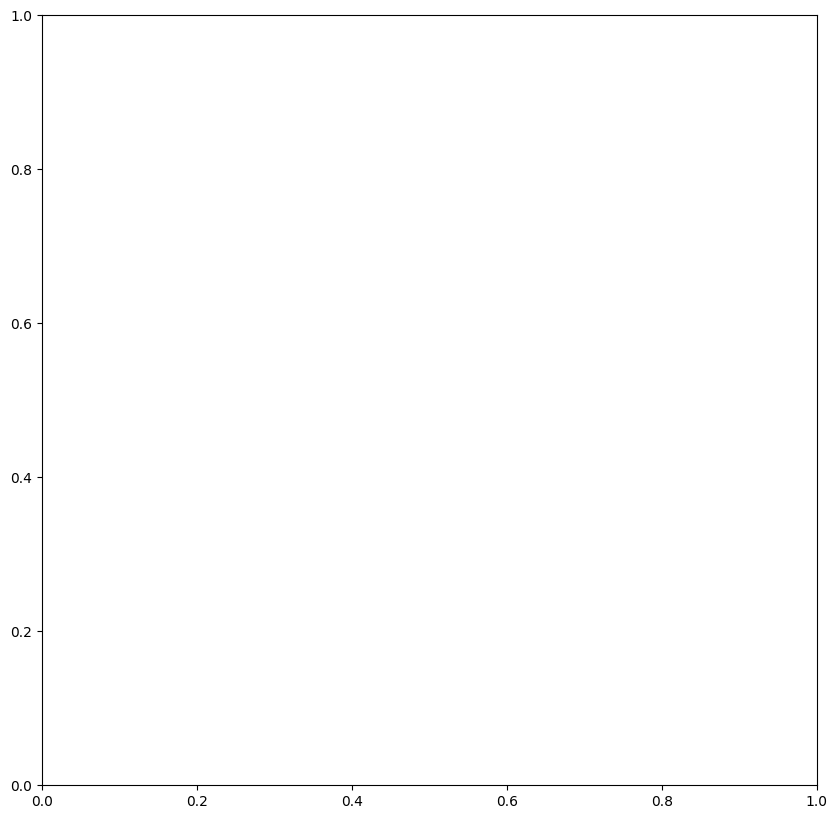

In [61]:
import geopandas as gpd
#import geodatasets
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Read back geocoded file
ga_jobs = pd.read_csv("/content/geocoded_jobs.csv")

# Create GeoDataFrame
ga_jobs = ga_jobs.dropna(subset=['lat', 'lon'])
geometry = [Point(xy) for xy in zip(ga_jobs.lon, ga_jobs.lat)]
geo_jobs = gpd.GeoDataFrame(ga_jobs, geometry=geometry, crs="EPSG:4326")

# Load Georgia state boundaries
#usa = gpd.read_file(geodatasets.get_path('usa_states'))
#georgia = usa[usa['name'] == 'Georgia']
#usa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#georgia = usa[(usa.name == "United States")]

#import geopandas as gpd
georgia = gpd.read_file('/content/tl_2019_13_cousub.shp')
georgia = georgia[georgia['NAME'] == 'Georgia']
georgia = georgia.to_crs("EPSG:4326")  # Match CRS


# Plot setup
fig, ax = plt.subplots(figsize=(10, 10))

# Plot state boundaries
georgia.plot(ax=ax, facecolor='none', edgecolor='black')

# Plot job points
geo_jobs.plot(ax=ax, color='red', markersize=10, alpha=0.5)

plt.title('Job Locations in Georgia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# # Plot
# fig, ax = plt.subplots(figsize=(10, 10))
# georgia.boundary.plot(ax=ax, color='black')
# geo_jobs.plot(ax=ax, markersize=10, color='red', alpha=0.5)
# plt.title("H-2A Employer Job Locations in Georgia")
# plt.axis('off')
# plt.show()